In [1]:
import os
import xml.etree.ElementTree as ex

os.environ["CUDA_VISIBLE_DEVICES"]="5"

sample_labels = ["CN", "EMCI"]
label_to_id = {}      # key: class name
                    # value: class id
file_to_apoe = {}   # key: image file path
                    # value: boolean, true if image specified 4 in either "APOE A1" or "APOE A2" fields

# This is for getting ADNI files
def get_filenames(folder, metadata_folder):
    global label_to_id
    for i, label in enumerate(sample_labels):
        label_to_id[label] = i
         
    # Get list of images
    image_class = {} # key: unique subject id in filename
                     # value: image file path
    for root, directories, filenames in os.walk(folder):
        for filename in filenames:
            if filename.endswith("nii") and "__Scaled_2" not in root:
                identifier = filename[-11:-4]
                image_class[identifier] = os.path.join(root,filename)
                
    meta_files = [f for f in os.listdir(metadata_folder) if f.endswith('xml')]
        
    # Label each image
    classify_by_label = {} # key: label class in [0, 1, 2, 3]
                           # value: list of image file paths
    for xml in meta_files:
        if "__Scaled_2" not in xml:
            identifier = xml[-11:-4]
            root = ex.parse(metadata_folder + "/" + xml).getroot()
            classification = root[0][3][1].text
            if classification in label_to_id:
                cl = label_to_id[classification]
                file_path = image_class[identifier]
                if cl not in classify_by_label:
                    classify_by_label[cl] = [file_path]
                else:
                    classify_by_label[cl].append(file_path)
                
                # Storing APOE e4 carrier information for each image file
                apoe_1 = root[0][3][4].text
                apoe_2 = root[0][3][5].text
                
                file_to_apoe[file_path] = False
                if apoe_1 == "4" or apoe_2 == "4":
                    file_to_apoe[file_path] = True
                    
    print("Statistics: {}".format(get_stats(classify_by_label)))
    
    return classify_by_label

def get_stats(files):
    stats = {}
    for k, v in files.items():
        stats[sample_labels[int(k)]] = len(v)
    return stats


In [2]:
import matplotlib.pyplot as plt
from nilearn import image
import nibabel as nib
import numpy as np
import tensorflow as tf
from scipy import ndimage as nd

def get_files(data_folder, metadata_folder):
    files = get_filenames(data_folder, metadata_folder)
    return files 

# Size of desired image
width = 80
height = 80
depth = 80

def get_data(files, class_id):
    global width, height, depth
    num_images = len(files)
    
    x_data = np.zeros([num_images, height, width, depth], np.float32)
    y_data = np.zeros(num_images, dtype=np.int32)
    
    for i in range(num_images):
        loaded_img = nib.load(files[i])    
        im = loaded_img.get_data()
        im = nd.interpolation.zoom(im, 
                                   zoom = np.array([height, width, depth])/im.shape)

        x_data[i] = np.asarray(im, dtype=np.float32)
        y_data[i] = class_id
    
    x_data_ = x_data.reshape(num_images, height * width * depth)
    return x_data_, y_data

In [3]:
def partition_data(num_result, class_data, class_id):
    random_inds = random.sample(range(0, len(class_data)), num_result)
    random_inds = sorted(random_inds, reverse=True)
    files = []
    for ind in random_inds:
        files.append(class_data.pop(ind))
    data, target = get_data(files, class_id)
    
    return data, target, files
    

In [4]:
import math
import random

# Get training data
files = get_files('ADNI2_all/ADNI', 'ADNI2_all/metadata')
num_samples = 0
flattened = [[] for i in range(len(sample_labels))]
for k, v in files.items():
    for f in v:
        flattened[k].append(f) 
        num_samples += 1

# Store APOE e4 carrier statistics on test data
apoe_test_files = []
e4_carrier_stats_pre = {}
for i in range(0, len(sample_labels)):
    e4_carrier_stats_pre[i] = 0
    
num_val_samples_per_cl = 8
num_test_samples_per_cl = 16

# Split training and testing data
tr_data = []
tr_target = []
val_data = []
val_target = []
test_data = []
test_target = []
for cl in range(0, len(flattened)): 
    # Get testing data
    data, target, files = partition_data(num_test_samples_per_cl, flattened[cl], cl)
    if len(test_data) == 0:
        test_data = data
        test_target = target
    else:
        test_data = np.append(test_data, data, axis=0)
        test_target = np.append(test_target, target)
                
    # Increment values if e4 carrier status
    apoe_test_files = np.append(apoe_test_files, files)
    for f in files:
        if file_to_apoe[f]:
            e4_carrier_stats_pre[cl] += 1
    
    # Get validation data
    data, target, files = partition_data(num_val_samples_per_cl, flattened[cl], cl)
    if len(val_data) == 0:
        val_data = data
        val_target = target
    else:
        val_data = np.append(val_data, data, axis=0)
        val_target = np.append(val_target, target)
    
    # Get training data
    data, target = get_data(flattened[cl], cl)
    if len(tr_data) == 0:
        tr_data = data
        tr_target = target
    else:
        tr_data = np.append(tr_data, data, axis=0)
        tr_target = np.append(tr_target, target)
    
# Print e4 carrier stats
for cl_id, quant in e4_carrier_stats_pre.items():
    print("Class {}. Pct APOE e4 carrier {}".format(sample_labels[cl_id], quant/num_test_samples_per_cl))

Statistics: {'EMCI': 264, 'CN': 228}
Class CN. Pct APOE e4 carrier 0.375
Class EMCI. Pct APOE e4 carrier 0.6875


In [5]:
def weight(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv3d(x, W, bias, strides=[1, 1, 1, 1, 1]):
    conv = tf.nn.conv3d(x, W, strides, padding='SAME') 
    bias = tf.nn.bias_add(conv, bias)
    return tf.nn.relu(bias)

def batch_norm(x, training):
    return tf.layers.batch_normalization(x, training = training)

def max_pool_2x2(x):
    return tf.nn.max_pool3d(x, ksize=[1, 2, 2, 2, 1], strides=[1, 2, 2, 2, 1], padding='SAME')

In [6]:
# Create network
tf.reset_default_graph()

x = tf.placeholder(shape = [None, width*height*depth],
                   dtype = tf.float32)
training = tf.placeholder(shape = None,
                          dtype = tf.bool)

x_image = tf.reshape(x, [-1, height, width, depth, 1])

# Block 1
W = weight([3, 3, 3, 1, 8])
b = bias([8])
conv1 = conv3d(x_image, W, b)

W = weight([3, 3, 3, 8, 8])
conv2 = conv3d(conv1, W, b)
pool = max_pool_2x2(conv2)

# Block 2
W = weight([3, 3, 3, 8, 16])
b = bias([16])
conv3 = conv3d(pool, W, b)

W = weight([3, 3, 3, 16, 16])
conv4 = conv3d(conv3, W, b)
pool = max_pool_2x2(conv4)

# Block 3
W = weight([3, 3, 3, 16, 32])
b = bias([32])
conv5 = conv3d(pool, W, b)

W = weight([3, 3, 3, 32, 32])
conv6 = conv3d(conv5, W, b)
conv7 = conv3d(conv6, W, b)
conv8 = conv3d(conv7, W, b)
pool = max_pool_2x2(conv8)

# Block 4
W = weight([3, 3, 3, 32, 64])
b = bias([64])
conv9 = conv3d(pool, W, b)

W = weight([3, 3, 3, 64, 64])
# conv10 = conv3d(conv9, W, b)
conv11 = conv3d(conv9, W, b)
conv12 = conv3d(conv11, W, b)
pool = max_pool_2x2(conv12)

# Block 5
W = weight([3, 3, 3, 64, 128])
b = bias([128])
conv13 = conv3d(pool, W, b)

W = weight([3, 3, 3, 128, 128])
conv14 = conv3d(conv13, W, b)
conv15 = conv3d(conv14, W, b)
conv16 = conv3d(conv15, W, b)
pool = max_pool_2x2(conv16)

# Densely Connected Layer (or fully-connected layer)
pool_flat = tf.layers.flatten(pool)
fcl17 = tf.layers.dense(pool_flat, units=128, activation = tf.nn.relu)
bn = batch_norm(fcl17, training)
fcl18 = tf.layers.dense(bn, units=64, activation = tf.nn.relu)
logits = tf.layers.dense(fcl18,
                         units = len(sample_labels),
                         activation = tf.nn.softmax)

# Loss
y_ = tf.placeholder(shape = [None],
                    dtype = tf.int32)
y_onehot = tf.one_hot(y_, len(sample_labels))
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_onehot, 
                                                                 logits=logits))

# Classification Accuracy
predicted = tf.argmax(logits, 1)
correct_prediction = tf.equal(predicted, tf.argmax(y_onehot, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Optimizer
opt = tf.train.AdamOptimizer(27e-6).minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [7]:
# Plotting variables
x_train = []
y_train = []
x_val = []
y_val = []
x_tr_acc = []
y_tr_acc = []
x_val_acc = []
y_val_acc = []

def plotting(train_loss, val_loss, train_acc, val_acc, final=False):
    if final:
        plt.figure(figsize=(20,10))
    plt.scatter(train_loss[0], train_loss[1], color='g', s=1, label='training')
    plt.scatter(val_loss[0], val_loss[1], color='r', s=1, label='validation')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend()
    plt.show()

    if final:
        plt.figure(figsize=(20,10))
    plt.scatter(train_acc[0], train_acc[1], color='g', s=1, label='training')
    plt.scatter(val_acc[0], val_acc[1], color='r', s=1, label='validation')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.legend()
    plt.show()


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Last loss 0. Curr loss 0.8132616281509399.
Epoch 0. TrainL 0.6842370629310608. ValL 0.8132616281509399. Acc 0.5.


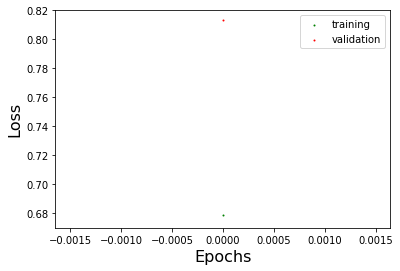

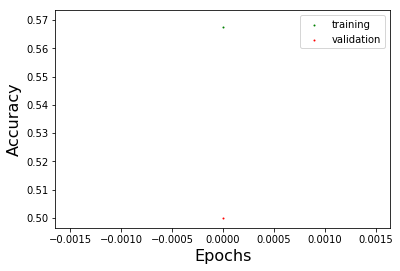

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Last loss 0.8132616281509399. Curr loss 0.8132616281509399.
Epoch 1. TrainL 0.6677587032318115. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 0 0 1 1 1 0 1 1 0 1 1 0 1]
Last loss 0.8132616281509399. Curr loss 0.8340950012207031.
Epoch 2. TrainL 0.6141844987869263. ValL 0.8757616281509399. Acc 0.4375.
[1 1 1 0 0 1 1 1 0 1 1 0 1 0 0 1]
Last loss 0.8340950012207031. Curr loss 0.8601366281509399.
Epoch 3. TrainL 0.5261502265930176. ValL 0.9382616281509399. Acc 0.375.
[0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 1]
Last loss 0.8601366281509399. Curr loss 0.8507615923881531.
Epoch 4. TrainL 0.5145710706710815. ValL 0.8132616281509399. Acc 0.5.
[1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1]
Last loss 0.8507615923881531. Curr loss 0.8445115685462952.
Epoch 5. TrainL 0.5004777908325195. ValL 0.8132616281509399. Acc 0.5.
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Last loss 0.8445115685462952. Curr loss 0.840047299861908.
Epoch 6. TrainL 0.5525742769241333. ValL 0.8132616281509399. Acc 0.5.
[1 0 1 0 0 1

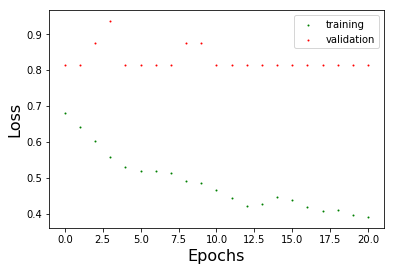

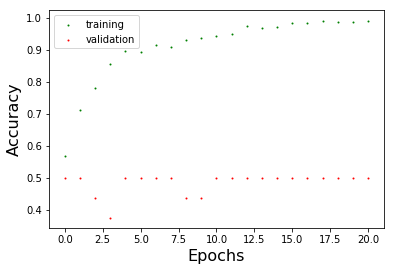

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Last loss 0.8281426429748535. Curr loss 0.8274661898612976.
Epoch 21. TrainL 0.4063356816768646. ValL 0.8132616281509399. Acc 0.5.
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Last loss 0.8274661898612976. Curr loss 0.826848566532135.
Epoch 22. TrainL 0.3965408504009247. ValL 0.8132616281509399. Acc 0.5.
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Last loss 0.826848566532135. Curr loss 0.8262825012207031.
Epoch 23. TrainL 0.3755853772163391. ValL 0.8132616281509399. Acc 0.5.
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Last loss 0.8262825012207031. Curr loss 0.825761616230011.
Epoch 24. TrainL 0.3582630753517151. ValL 0.8132616281509399. Acc 0.5.
[0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0]
Last loss 0.825761616230011. Curr loss 0.8252808451652527.
Epoch 25. TrainL 0.3593387007713318. ValL 0.8132616281509399. Acc 0.5.
[0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0]
Last loss 0.8252808451652527. Curr loss 0.8202060461044312.
Epoch 26. TrainL 0.3510548174381256. ValL 0.6882616281509399. Acc 0.625.
[0 0 0 0 0 0

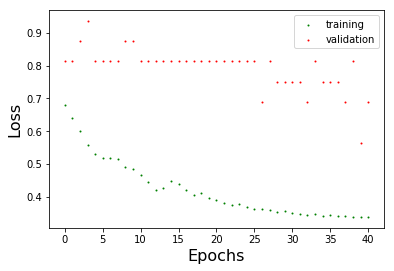

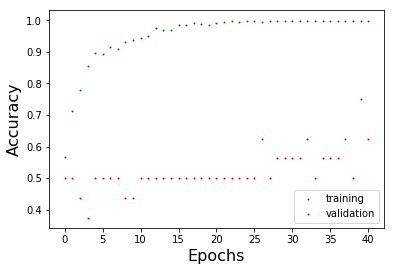

[1 0 1 0 0 1 1 0 0 1 1 1 1 1 0 1]
Last loss 0.7919201850891113. Curr loss 0.7894521355628967.
Epoch 41. TrainL 0.3295617401599884. ValL 0.6882616281509399. Acc 0.625.
[1 0 1 0 0 0 1 0 0 1 1 1 1 1 0 1]
Last loss 0.7894521355628967. Curr loss 0.7856454253196716.
Epoch 42. TrainL 0.33370551466941833. ValL 0.6257616281509399. Acc 0.6875.
[0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1]
Last loss 0.7856454253196716. Curr loss 0.7805912494659424.
Epoch 43. TrainL 0.3549453616142273. ValL 0.5632616281509399. Acc 0.75.
[1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1]
Last loss 0.7805912494659424. Curr loss 0.7757617235183716.
Epoch 44. TrainL 0.3313516080379486. ValL 0.5632616281509399. Acc 0.75.
[1 0 1 0 0 0 0 0 0 0 1 0 1 1 0 1]
Last loss 0.7757617235183716. Curr loss 0.7738596200942993.
Epoch 45. TrainL 0.3280164301395416. ValL 0.6882616281509399. Acc 0.625.
[1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1]
Last loss 0.7738596200942993. Curr loss 0.7707086205482483.
Epoch 46. TrainL 0.35544896125793457. ValL 0.6257616281509399. Acc 0.68

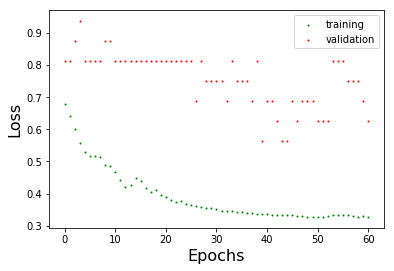

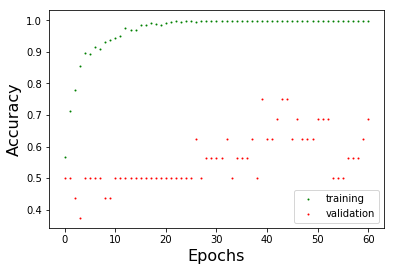

[1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1]
Last loss 0.7382616400718689. Curr loss 0.7345116138458252.
Epoch 61. TrainL 0.32494625449180603. ValL 0.6257616281509399. Acc 0.6875.
[1 0 1 0 0 1 1 0 1 1 1 1 1 1 0 1]
Last loss 0.7345116138458252. Curr loss 0.7307616472244263.
Epoch 62. TrainL 0.32324475049972534. ValL 0.6257616281509399. Acc 0.6875.
[1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1]
Last loss 0.7307616472244263. Curr loss 0.7257616519927979.
Epoch 63. TrainL 0.3313376009464264. ValL 0.5632616281509399. Acc 0.75.
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1]
Last loss 0.7257616519927979. Curr loss 0.7195116281509399.
Epoch 64. TrainL 0.32580190896987915. ValL 0.5007616281509399. Acc 0.8125.
[1 0 1 1 0 1 1 0 1 1 1 1 1 1 0 1]
Last loss 0.7195116281509399. Curr loss 0.7170116305351257.
Epoch 65. TrainL 0.32210856676101685. ValL 0.6882616281509399. Acc 0.625.
[1 0 1 0 0 1 1 0 1 1 1 1 1 1 0 1]
Last loss 0.7170116305351257. Curr loss 0.7132616639137268.
Epoch 66. TrainL 0.3204580545425415. ValL 0.6257616281509399. Acc

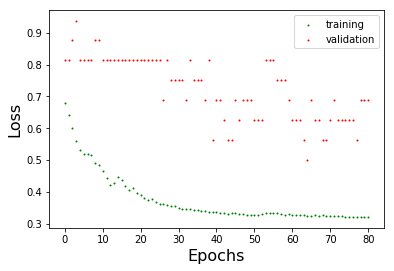

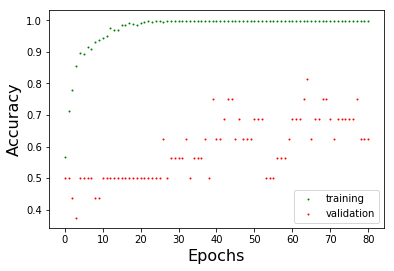

[1 1 1 0 0 1 1 0 1 1 1 1 1 1 0 1]
Last loss 0.6682616472244263. Curr loss 0.6670116186141968.
Epoch 81. TrainL 0.34543681144714355. ValL 0.6882616281509399. Acc 0.625.
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1]
Last loss 0.6670116186141968. Curr loss 0.6632616519927979.
Epoch 82. TrainL 0.31962767243385315. ValL 0.5007616281509399. Acc 0.8125.
[1 0 1 0 0 1 1 0 1 1 1 1 1 1 0 1]
Last loss 0.6632616519927979. Curr loss 0.6595116257667542.
Epoch 83. TrainL 0.31861382722854614. ValL 0.6257616281509399. Acc 0.6875.
[1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1]
Last loss 0.6595116257667542. Curr loss 0.6582616567611694.
Epoch 84. TrainL 0.3166199028491974. ValL 0.6882616281509399. Acc 0.625.
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1]
Last loss 0.6582616567611694. Curr loss 0.6520116329193115.
Epoch 85. TrainL 0.3182583451271057. ValL 0.43826162815093994. Acc 0.875.
[1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1]
Last loss 0.6520116329193115. Curr loss 0.6507615447044373.
Epoch 86. TrainL 0.3198082447052002. ValL 0.6882616281509399. Acc

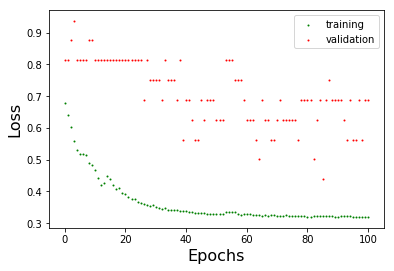

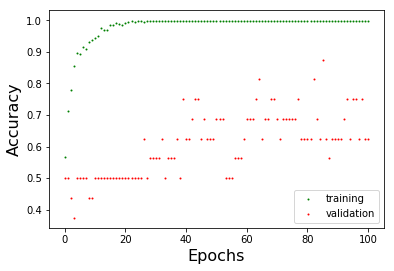

[1 0 1 0 0 1 1 0 1 1 1 1 1 1 0 1]
Last loss 0.6495115756988525. Curr loss 0.6495115756988525.
Epoch 101. TrainL 0.31867361068725586. ValL 0.6257616281509399. Acc 0.6875.
[1 0 1 0 0 0 1 0 1 1 1 1 1 1 0 1]
Last loss 0.6495115756988525. Curr loss 0.648261547088623.
Epoch 102. TrainL 0.3173227906227112. ValL 0.5632616281509399. Acc 0.75.
[1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1]
Last loss 0.648261547088623. Curr loss 0.6457615494728088.
Epoch 103. TrainL 0.3168575167655945. ValL 0.6882616281509399. Acc 0.625.
[1 0 1 0 0 0 0 0 1 1 1 1 1 1 0 1]
Last loss 0.6457615494728088. Curr loss 0.6395115852355957.
Epoch 104. TrainL 0.3182237446308136. ValL 0.5007616281509399. Acc 0.8125.
[1 0 1 1 0 1 1 0 1 1 1 1 1 1 0 1]
Last loss 0.6395115852355957. Curr loss 0.6370115876197815.
Epoch 105. TrainL 0.35082507133483887. ValL 0.6882616281509399. Acc 0.625.
[1 0 1 0 0 1 0 0 0 1 1 1 1 1 0 1]
Last loss 0.6370115876197815. Curr loss 0.6345115900039673.
Epoch 106. TrainL 0.31955310702323914. ValL 0.6257616281509399. A

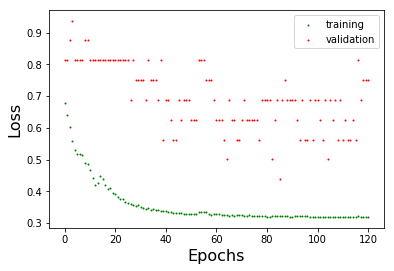

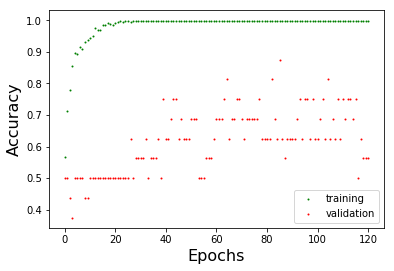

[1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1]
Last loss 0.6420115828514099. Curr loss 0.6420115828514099.
Epoch 121. TrainL 0.34732115268707275. ValL 0.6882616281509399. Acc 0.625.
[1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1]
Last loss 0.6420115828514099. Curr loss 0.6445115804672241.
Epoch 122. TrainL 0.3155292868614197. ValL 0.7507616281509399. Acc 0.5625.
[1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1]
Last loss 0.6445115804672241. Curr loss 0.6470115780830383.
Epoch 123. TrainL 0.3152424693107605. ValL 0.7507616281509399. Acc 0.5625.
[1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1]
Last loss 0.6470115780830383. Curr loss 0.6457615494728088.
Epoch 124. TrainL 0.3164430260658264. ValL 0.5632616281509399. Acc 0.75.
[1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1]
Last loss 0.6457615494728088. Curr loss 0.6457615494728088.
Epoch 125. TrainL 0.3392806947231293. ValL 0.6257616281509399. Acc 0.6875.
[1 0 1 1 0 0 1 0 0 1 1 1 1 1 0 1]
Last loss 0.6457615494728088. Curr loss 0.6470115780830383.
Epoch 126. TrainL 0.32383695244789124. ValL 0.6882616281509399.

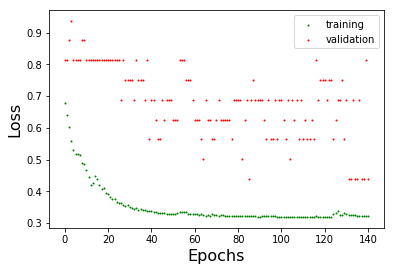

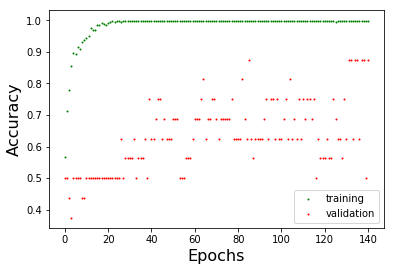

[0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1]
Last loss 0.6245115399360657. Curr loss 0.6195115447044373.
Epoch 141. TrainL 0.31650567054748535. ValL 0.43826162815093994. Acc 0.875.
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1]
Last loss 0.6195115447044373. Curr loss 0.6157615780830383.
Epoch 142. TrainL 0.32248029112815857. ValL 0.43826162815093994. Acc 0.875.
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1]
Last loss 0.6157615780830383. Curr loss 0.6145115494728088.
Epoch 143. TrainL 0.3159564137458801. ValL 0.5007616281509399. Acc 0.8125.
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1]
Last loss 0.6145115494728088. Curr loss 0.6095115542411804.
Epoch 144. TrainL 0.32192516326904297. ValL 0.43826162815093994. Acc 0.875.
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1]
Last loss 0.6095115542411804. Curr loss 0.6082615852355957.
Epoch 145. TrainL 0.31912973523139954. ValL 0.5007616281509399. Acc 0.8125.
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1]
Last loss 0.6082615852355957. Curr loss 0.6070115566253662.
Epoch 146. TrainL 0.3152652680873871. ValL 0.500761628150

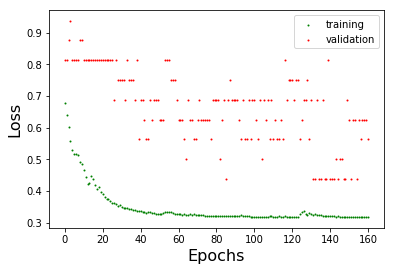

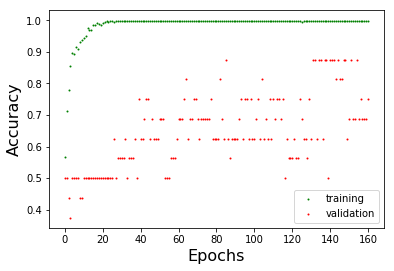

[1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1]
Last loss 0.5895115733146667. Curr loss 0.5895115733146667.
Epoch 161. TrainL 0.3183479905128479. ValL 0.6257616281509399. Acc 0.6875.
[1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1]
Last loss 0.5895115733146667. Curr loss 0.5907615423202515.
Epoch 162. TrainL 0.3166990280151367. ValL 0.6257616281509399. Acc 0.6875.
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1]
Last loss 0.5907615423202515. Curr loss 0.5895115733146667.
Epoch 163. TrainL 0.3165251910686493. ValL 0.5007616281509399. Acc 0.8125.
[1 0 1 1 0 0 1 0 1 1 1 1 1 1 0 1]
Last loss 0.5895115733146667. Curr loss 0.5895115733146667.
Epoch 164. TrainL 0.31506383419036865. ValL 0.6257616281509399. Acc 0.6875.
[1 0 1 1 0 0 1 0 1 1 1 1 1 1 0 1]
Last loss 0.5895115733146667. Curr loss 0.5907615423202515.
Epoch 165. TrainL 0.3145953416824341. ValL 0.6257616281509399. Acc 0.6875.
[1 0 1 1 0 0 1 0 1 1 1 1 1 1 0 1]
Last loss 0.5907615423202515. Curr loss 0.5870115756988525.
Epoch 166. TrainL 0.3151511549949646. ValL 0.625761628150939

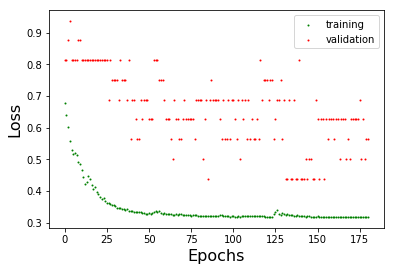

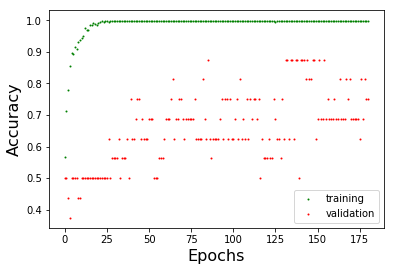

[0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1]
Last loss 0.5557615756988525. Curr loss 0.5557615756988525.
Epoch 181. TrainL 0.31436648964881897. ValL 0.43826162815093994. Acc 0.875.
[1 0 1 1 0 0 1 0 1 1 1 1 1 1 0 1]
Last loss 0.5557615756988525. Curr loss 0.5595115423202515.
Epoch 182. TrainL 0.31453341245651245. ValL 0.6257616281509399. Acc 0.6875.
[1 0 1 1 0 0 1 0 0 1 1 1 1 1 0 1]
Last loss 0.5595115423202515. Curr loss 0.5595115423202515.
Epoch 183. TrainL 0.3148919641971588. ValL 0.6882616281509399. Acc 0.625.
[0 0 0 1 0 0 1 0 0 1 1 1 1 1 0 1]
Last loss 0.5595115423202515. Curr loss 0.5620115399360657.
Epoch 184. TrainL 0.3142797648906708. ValL 0.5632616281509399. Acc 0.75.
[1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 1]
Last loss 0.5620115399360657. Curr loss 0.5645115375518799.
Epoch 185. TrainL 0.3142111599445343. ValL 0.5632616281509399. Acc 0.75.
[0 0 0 0 0 0 1 0 0 1 1 1 1 1 0 1]
Last loss 0.5645115375518799. Curr loss 0.560761570930481.
Epoch 186. TrainL 0.3145139813423157. ValL 0.5007616281509399. Ac

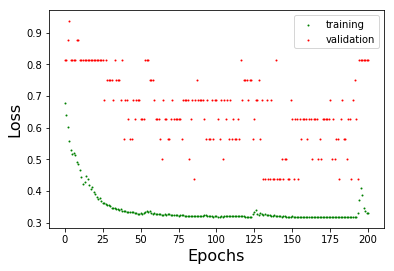

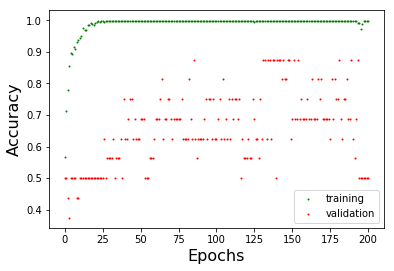

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.6157615780830383. Curr loss 0.623261570930481.
Epoch 201. TrainL 0.3198930323123932. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.623261570930481. Curr loss 0.6270115375518799.
Epoch 202. TrainL 0.32400763034820557. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.6270115375518799. Curr loss 0.6307615637779236.
Epoch 203. TrainL 0.3222848176956177. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.6307615637779236. Curr loss 0.6382615566253662.
Epoch 204. TrainL 0.3231014013290405. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.6382615566253662. Curr loss 0.6420115828514099.
Epoch 205. TrainL 0.31859177350997925. ValL 0.8132616281509399. Acc 0.5.
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Last loss 0.6420115828514099. Curr loss 0.6470115780830383.
Epoch 206. TrainL 0.3176088333129883. ValL 0.8132616281509399. Acc 0.5.
[1 1

In [8]:
saver = tf.train.Saver()

# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())

# Params for early stopping
patience = 16
patience_cnt = 0
hist_len = 50
last_avg_loss = 0
hist_loss = []
min_loss_seen = None

batch_size = 32
epoch = 0
while (patience_cnt < patience or epoch < hist_len) and epoch < 1000:
    c = list(zip(tr_data, tr_target))
    random.shuffle(c)
    tr_data, tr_target = zip(*c)

    tr_loss, val_loss, tr_acc, val_acc = (0, 0, 0, 0)
    for j in range(0, len(tr_target), batch_size):

        # Validation conditions
        if j == 0:
            # Get accuracy and loss from validation data
            vLoss, vAcc, vPred = sess.run([loss, accuracy, predicted], 
                                          feed_dict = {x: val_data,
                                                       y_: val_target,
                                                       training: False})
                   
            print(vPred)
            
            # Conditions for early stopping
            if len(hist_loss) == hist_len:
                hist_loss.pop(0)
            hist_loss.append(vLoss)
            curr_loss = np.mean(np.asarray(hist_loss)) 
            
            print("Last loss {}. Curr loss {}.".format(last_avg_loss, curr_loss))
            
            if last_avg_loss > curr_loss:
                patience_cnt = 0
                
                # Save the model 
                if min_loss_seen == None or min_loss_seen > curr_loss:
                    min_loss_seen = curr_loss
                    saver.save(sess, './braincnn-18-model', global_step=epoch)
                    saver.save(sess, './braincnn-18-model-final')
            elif last_avg_loss == curr_loss:
                patience_cnt = 0
            else:
                if epoch >= hist_len:
                    patience_cnt += 1
                
            last_avg_loss = curr_loss
                
        # Training
        rOpt, rLoss, rAcc = sess.run([opt, loss, accuracy], 
                                     feed_dict = {x: tr_data[j:j + batch_size],
                                                  y_: tr_target[j:j + batch_size],
                                                  training: True})

        # Accumulate loss and accuracy stats to later calculate average of epoch
        tr_loss += rLoss
        val_loss += vLoss
        tr_acc += rAcc
        val_acc += vAcc

        if j == 0:
            print('Epoch {}. TrainL {}. ValL {}. Acc {}.'.format(epoch, rLoss, vLoss, vAcc))
    
    num_mini_batches = math.ceil(len(tr_target)/batch_size)
    x_train.append(epoch)
    y_train.append(tr_loss/num_mini_batches)
    x_val.append(epoch)
    y_val.append(val_loss/num_mini_batches)
    x_tr_acc.append(epoch)
    y_tr_acc.append(tr_acc/num_mini_batches)
    x_val_acc.append(epoch)
    y_val_acc.append(val_acc/num_mini_batches)
    
    # Plotting every 20 epochs
    if epoch % 20 == 0:
        plotting((x_train, y_train), (x_val, y_val), (x_tr_acc, y_tr_acc), (x_val_acc, y_val_acc))
    
    # Next epoch
    epoch += 1


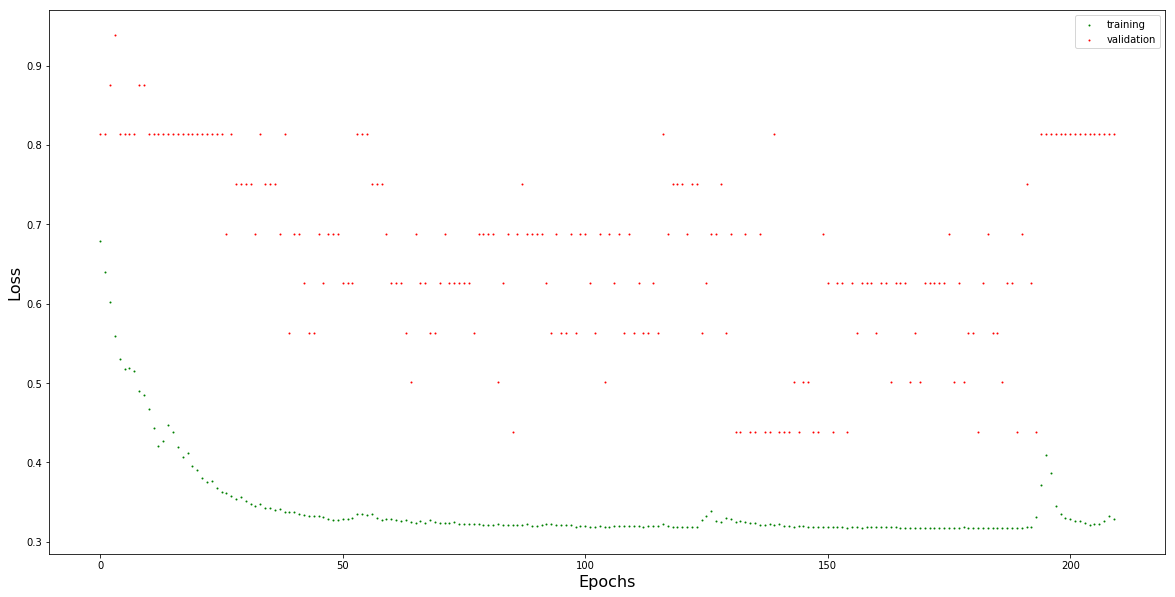

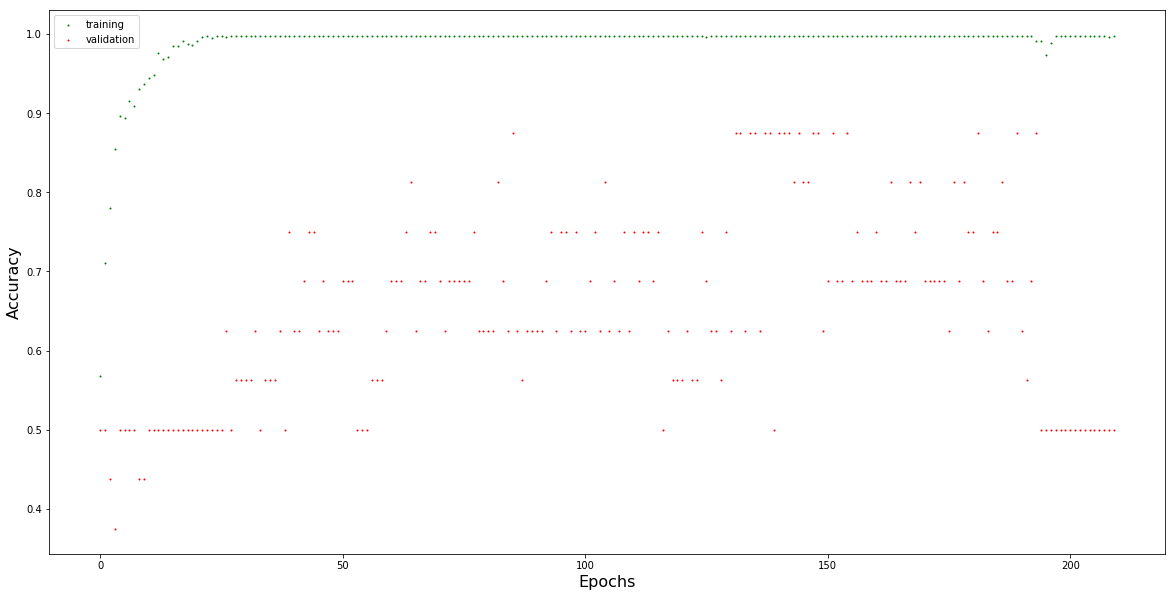

In [9]:
# Plot final graph
plotting((x_train, y_train), (x_val, y_val), (x_tr_acc, y_tr_acc), (x_val_acc, y_val_acc), final=True)


In [10]:
# Need to restore model saved by early stopping
with tf.Session() as sSess:
    # Restore variables.
    saver.restore(sSess, './braincnn-18-model-final')
    print("Model restored.")
              
    # Get accuracy and loss from validation data
    sAcc, sPred = sSess.run([accuracy, predicted], 
                            feed_dict = {x: test_data,
                                         y_: test_target,
                                         training: False})
    
    print('Predicted classes {}'.format(sPred))
    print('Testing accuracy {}'.format(sAcc))

    # APOE e4 stats for testing data
    e4_carrier_stats_post = {}
    for k in range(0, len(sample_labels)):
        e4_carrier_stats_post[k] = [0, 0]

    # Get testing APOE e4 stats
    for p in range(0, len(sPred)):
        e4_carrier_stats_post[sPred[p]][1] += 1
        if file_to_apoe[apoe_test_files[p]]:
            e4_carrier_stats_post[sPred[p]][0] += 1

    for cl_id, [quant, num_samples] in e4_carrier_stats_post.items():
        if num_samples != 0:
            print("Class {}. Pct APOE e4 carrier {}".format(sample_labels[cl_id], 
                                                            quant/num_samples))

INFO:tensorflow:Restoring parameters from ./braincnn-18-model-final
Model restored.
Predicted classes [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]
Testing accuracy 0.9375
Class CN. Pct APOE e4 carrier 0.375
Class EMCI. Pct APOE e4 carrier 0.6875
